# Quantifying Trading Behavior in Financial Markets using Google Trends

# Notebook setup

In [1]:
# necessary imports for the workbook
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas.io.data as web

# Set some pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 8)
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 78) 
pd.set_option('precision', 6)

# do all our graphics inline
%matplotlib inline

# Data organization

## Data from the paper

In [2]:
# this is the same DJIA data from the authors
paper = pd.read_csv('PreisMoatStanley2013.dat', 
                    delimiter=' ', 
                    parse_dates=[0,1,100,101])
paper[:5]

  Google Start Date Google End Date     arts  banking         ...          \
0        2004-01-04      2004-01-10  0.95667  0.19333         ...           
1        2004-01-11      2004-01-17  0.97000  0.20333         ...           
2        2004-01-18      2004-01-24  0.92667  0.19667         ...           
3        2004-01-25      2004-01-31  0.95000  0.19667         ...           
4        2004-02-01      2004-02-07  0.89333  0.20333         ...           

     water    world  DJIA Date  DJIA Closing Price  
0  1.91333  4.83333 2004-01-12            10485.18  
1  1.93333  4.76667 2004-01-20            10528.66  
2  1.89333  4.60000 2004-01-26            10702.51  
3  1.92000  4.53333 2004-02-02            10499.18  
4  1.88667  4.53333 2004-02-09            10579.03  

[5 rows x 102 columns]

In [3]:
data = pd.DataFrame({'GoogleWE': paper['Google End Date'],
                     'debt': paper['debt'].astype(np.float64),
                     'DJIADate': paper['DJIA Date'],
                     'DJIAClose': paper['DJIA Closing Price']
                         .astype(np.float64)})
data[:5]

   DJIAClose   DJIADate   GoogleWE     debt
0   10485.18 2004-01-12 2004-01-10  0.21000
1   10528.66 2004-01-20 2004-01-17  0.21000
2   10702.51 2004-01-26 2004-01-24  0.21000
3   10499.18 2004-02-02 2004-01-31  0.21333
4   10579.03 2004-02-09 2004-02-07  0.20000

## Gathering our own DJIA data from Quandl

In [4]:
# get the DJIA from Quandl for 2004-01-01 to 2011-02-28
import Quandl 
djia = Quandl.get("YAHOO/INDEX_DJI", 
                  trim_start='2004-01-01', 
                  trim_end='2011-03-05')

In [5]:
# alternatively, you can load it from this file provided
# with the books source code
# djia = pd.read_csv("djia.csv", index_col=0)

In [6]:
djia[:3]

               Open     High      Low    Close   Volume  Adjusted Close
Date                                                                   
2004-01-02  10452.7  10527.0  10384.3  10409.9  1688900         10409.9
2004-01-05  10411.9  10544.1  10411.9  10544.1  2212900         10544.1
2004-01-06  10543.9  10549.2  10499.9  10538.7  1914600         10538.7

In [7]:
djia_closes = djia['Close'].reset_index()
djia_closes[:3]

        Date    Close
0 2004-01-02  10409.9
1 2004-01-05  10544.1
2 2004-01-06  10538.7

In [8]:
data = pd.merge(data, djia_closes, 
                left_on='DJIADate', right_on='Date')
data.drop(['DJIADate'], inplace=True, axis=1)
data = data.set_index('Date')
data[:3]

            DJIAClose   GoogleWE  debt    Close
Date                                           
2004-01-12   10485.18 2004-01-10  0.21  10485.2
2004-01-20   10528.66 2004-01-17  0.21  10528.7
2004-01-26   10702.51 2004-01-24  0.21  10702.5

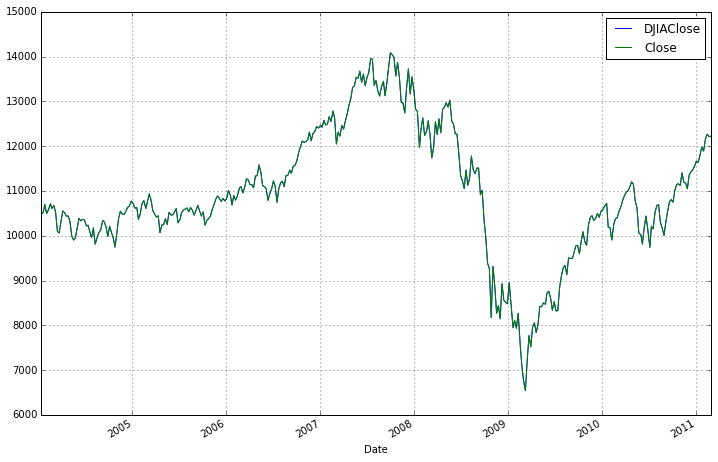

In [9]:
# examine authors versus our DJIA data
data[['DJIAClose', 'Close']].plot(figsize=(12,8));
#plt.savefig('5104OS_06_02.png', bbox_inches='tight', dpi=300)

In [10]:
(data['DJIAClose']-data['Close']).describe()

count    373.00000
mean      -0.00493
std        0.03003
min       -0.05000
25%       -0.03000
50%       -0.01000
75%        0.02000
max        0.04000
dtype: float64

In [11]:
data[['DJIAClose', 'Close']].corr()

           DJIAClose  Close
DJIAClose          1      1
Close              1      1

## Google trends data

In [12]:
# peek at the report for debt in the data folder
!head trends_report_debt.csv # on mac or linux
# type trends_report_debt.csv # on windows

Web Search interest: debt
United States; Jan 2004 - Feb 2011

Interest over time
Week,debt
2004-01-04 - 2004-01-10,63
2004-01-11 - 2004-01-17,60
2004-01-18 - 2004-01-24,61
2004-01-25 - 2004-01-31,63
2004-02-01 - 2004-02-07,61


In [13]:
from StringIO import StringIO
with open("trends_report_debt.csv") as f:
    data_section = f.read().split('\n\n')[1]
    trends_data = pd.read_csv(
        StringIO(data_section),
        header=1, index_col='Week',
        converters={
            'Week': lambda x: pd.to_datetime(x.split(' ')[-1])
        }
    )
our_debt_trends = trends_data['2004-01-01':'2011-02-28'] \
                              .reset_index()
our_debt_trends[:5]

        Week  debt
0 2004-01-10    63
1 2004-01-17    60
2 2004-01-24    61
3 2004-01-31    63
4 2004-02-07    61

In [14]:
final = pd.merge(data.reset_index(), our_debt_trends, 
                 left_on='GoogleWE', right_on='Week',
                 suffixes=['P', 'O'])
final.drop('Week', inplace=True, axis=1)
final.set_index('Date', inplace=True)
final[:5]

            DJIAClose   GoogleWE    debtP    Close  debtO
Date                                                     
2004-01-12   10485.18 2004-01-10  0.21000  10485.2     63
2004-01-20   10528.66 2004-01-17  0.21000  10528.7     60
2004-01-26   10702.51 2004-01-24  0.21000  10702.5     61
2004-02-02   10499.18 2004-01-31  0.21333  10499.2     63
2004-02-09   10579.03 2004-02-07  0.20000  10579.0     61

In [15]:
combined_trends = final[['GoogleWE', 'debtP', 'debtO']] \
                        .set_index('GoogleWE')
combined_trends[:5]

              debtP  debtO
GoogleWE                  
2004-01-10  0.21000     63
2004-01-17  0.21000     60
2004-01-24  0.21000     61
2004-01-31  0.21333     63
2004-02-07  0.20000     61

In [16]:
# what's the correlation?
combined_trends.corr()

         debtP    debtO
debtP  1.00000  0.95766
debtO  0.95766  1.00000

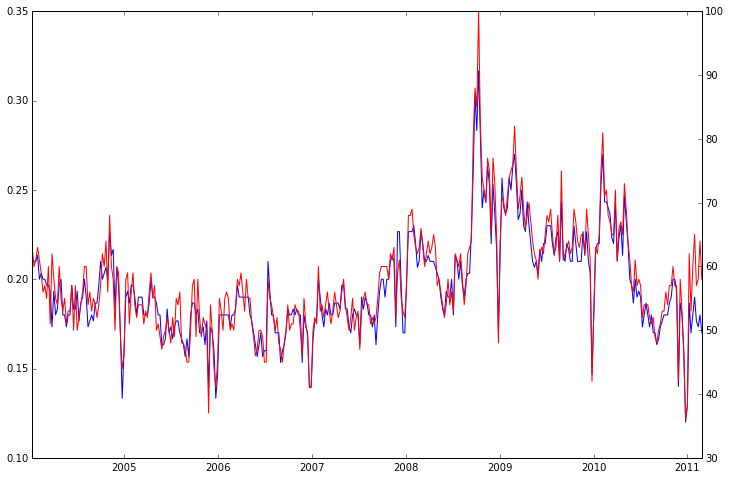

In [17]:
# visualize them together
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(combined_trends.index,
         combined_trends.debtP, color='b')
ax2 = ax1.twinx()
ax2.plot(combined_trends.index,
         combined_trends.debtO, color='r')
#plt.savefig('5104OS_06_05.png', bbox_inches='tight', dpi=300)
plt.show()

#plt.savefig('5104OS_06_05.png', bbox_inches='tight', dpi=300)

# Generate the order signals

In [18]:
base = final.reset_index().set_index('GoogleWE')
base.drop(['DJIAClose'], inplace=True, axis=1)
base[:3]

                 Date  debtP    Close  debtO
GoogleWE                                    
2004-01-10 2004-01-12   0.21  10485.2     63
2004-01-17 2004-01-20   0.21  10528.7     60
2004-01-24 2004-01-26   0.21  10702.5     61

In [19]:
# calculate the rolling mean of the previous three 
# weeks for each week
base['PMA'] = pd.rolling_mean(base.debtP.shift(1), 3)
base['OMA'] = pd.rolling_mean(base.debtO.shift(1), 3)
base[:5]

                 Date    debtP    Close  debtO      PMA       OMA
GoogleWE                                                         
2004-01-10 2004-01-12  0.21000  10485.2     63      NaN       NaN
2004-01-17 2004-01-20  0.21000  10528.7     60      NaN       NaN
2004-01-24 2004-01-26  0.21000  10702.5     61      NaN       NaN
2004-01-31 2004-02-02  0.21333  10499.2     63  0.21000  61.33333
2004-02-07 2004-02-09  0.20000  10579.0     61  0.21111  61.33333

In [20]:
# calculate the order signals
# for the papers data
base['signal0'] = 0 # default to 0
base.loc[base.debtP > base.PMA, 'signal0'] = -1 
base.loc[base.debtP < base.PMA, 'signal0'] = 1

# and for our trend data
base['signal1'] = 0
base.loc[base.debtO > base.OMA, 'signal1'] = -1
base.loc[base.debtO < base.OMA, 'signal1'] = 1
base[['debtP', 'PMA', 'signal0', 'debtO', 'OMA', 'signal1']]

              debtP      PMA  signal0  debtO       OMA  signal1
GoogleWE                                                       
2004-01-10  0.21000      NaN        0     63       NaN        0
2004-01-17  0.21000      NaN        0     60       NaN        0
2004-01-24  0.21000      NaN        0     61       NaN        0
2004-01-31  0.21333  0.21000       -1     63  61.33333       -1
2004-02-07  0.20000  0.21111        1     61  61.33333        1
...             ...      ...      ...    ...       ...      ...
2011-01-29  0.19000  0.17889       -1     65  58.33333       -1
2011-02-05  0.17667  0.18000        1     57  59.33333        1
2011-02-12  0.17333  0.18222        1     58  60.66667        1
2011-02-19  0.18000  0.18000        1     64  60.00000       -1
2011-02-26  0.17000  0.17667        1     58  59.66667        1

[373 rows x 6 columns]

# Computing Returns

In [21]:
# add in next week's percentage change to each week of data
base['PctChg'] = base.Close.pct_change().shift(-1)
base[['Close', 'PctChg', 'signal0', 'signal1']][:5]

              Close   PctChg  signal0  signal1
GoogleWE                                      
2004-01-10  10485.2  0.00415        0        0
2004-01-17  10528.7  0.01651        0        0
2004-01-24  10702.5 -0.01900        0        0
2004-01-31  10499.2  0.00760       -1       -1
2004-02-07  10579.0  0.01285        1        1

In [22]:
# calculate the returns
base['ret0'] = base.PctChg * base.signal0
base['ret1'] = base.PctChg * base.signal1
base[['Close', 'PctChg', 'signal0', 'signal1', 
      'ret0', 'ret1']][:5]

              Close   PctChg  signal0  signal1     ret0     ret1
GoogleWE                                                        
2004-01-10  10485.2  0.00415        0        0  0.00000  0.00000
2004-01-17  10528.7  0.01651        0        0  0.00000  0.00000
2004-01-24  10702.5 -0.01900        0        0 -0.00000 -0.00000
2004-01-31  10499.2  0.00760       -1       -1 -0.00760 -0.00760
2004-02-07  10579.0  0.01285        1        1  0.01285  0.01285

# Cumulative returns and the result of the strategy

In [23]:
# calculate and report the cumulative returns
base['cumret0'] = (1 + base.ret0).cumprod() - 1
base['cumret1'] = (1 + base.ret1).cumprod() - 1
base[['cumret0', 'cumret1']]

            cumret0  cumret1
GoogleWE                    
2004-01-10  0.00000  0.00000
2004-01-17  0.00000  0.00000
2004-01-24  0.00000  0.00000
2004-01-31 -0.00760 -0.00760
2004-02-07  0.00515  0.00515
...             ...      ...
2011-01-29  2.70149  0.84652
2011-02-05  2.73394  0.86271
2011-02-12  2.71707  0.85430
2011-02-19  2.72118  0.85225
2011-02-26      NaN      NaN

[373 rows x 2 columns]

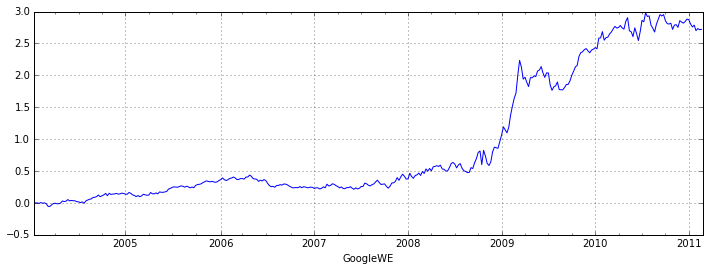

In [24]:
# show graph of growth for the papers data
base['cumret0'].plot(figsize=(12,4));
#plt.savefig('5104OS_06_06.png', bbox_inches='tight', dpi=300)

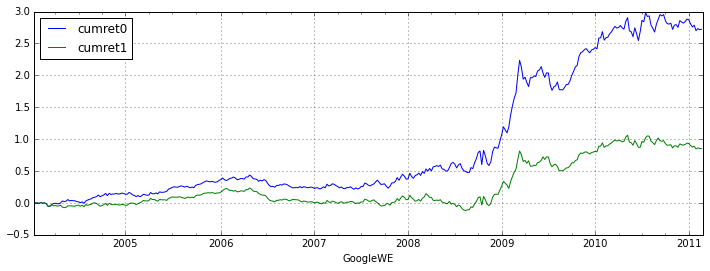

In [25]:
# show graph of growth for the papers data
base[['cumret0', 'cumret1']].plot(figsize=(12,4));
#plt.savefig('5104OS_06_07.png', bbox_inches='tight', dpi=300)